In [25]:
# disable warnings
import warnings
warnings.filterwarnings('ignore')
TOPAZ = ("topaz","f071c66c")
WITTI = ("witti","f6775d07")
ALTONA = ("altona","fdca39b0") 
MEDALLA = ("medalla","e7a75d5a") 

In [26]:
NETWORK,FORK_DIGEST=MEDALLA
LOAD_SESSION=False

In [27]:
import pandas as pd
from pathlib import Path
import glob
import os
import pickle
from bs4 import BeautifulSoup
from urllib.request import Request, urlopen
import json

def load_crawl_data(network, fork_digest, from_pickel):
    dfs = []
    start = 12000
    path = str(Path.home())+"/.{}/".format(network)
    if from_pickel:
        file = open('../data/{}-crawl-data.pkl'.format(network), 'rb')
        (df_all_with_dups, df_all, df, tot_num_nodes, num_nodes) = pickle.load(file)
        file.close()
    else:
        pattern = "{}{}".format(path,"crawler*")
        numFiles = len(glob.glob(pattern)) #!ls -l ~/.$network/crawler* |wc -l
        end = start + numFiles
        for port in list(range(start,end)):
            file = path+"/crawler"+str(port)+".csv"
            df = pd.read_csv(file) 
            df.drop(columns=['index'])
            dfs.append(df)

        df_all_with_dups = pd.concat(dfs).reset_index(drop=True).sort_values(by=['seq_no'], ascending=False) #ensure we keep highest seq no
        df_all = df_all_with_dups.drop_duplicates(subset="node_id", keep = 'first').reset_index(drop=True)
        df_all.set_index('node_id')
        df = df_all[df_all['fork_digest']==fork_digest]
        tot_num_nodes = len(df_all)
        num_nodes = len(df)
        file = open('../data/{}-crawl-data.pkl'.format(NETWORK), 'wb')
        foo = (df_all_with_dups, df_all, df, tot_num_nodes, num_nodes)
        pickle.dump(foo,file)
        file.close()
        
    return (df_all_with_dups, df_all, df, tot_num_nodes, num_nodes)

def load_consensus_data(network,from_pickel):
    active_validators = 0
    path = str(Path.home())+"/.{}/".format(network)
    
    if from_pickel:
        file = open('../data/{}-consensus-data.pkl'.format(network), 'rb')
        active_validators = pickle.load(file)
        file.close()
    else:

        url = "https://{}.beaconcha.in".format(network);
        req = Request(url, headers={'User-Agent': 'Mozilla/5.0'})
        response = urlopen(req)
        bs = BeautifulSoup(response.read(), 'html.parser')
        target = '"active_validators":'
        for tag in bs.find_all('script'):
            if target in tag.get_text():
                text = tag.get_text()
                start_index = text.index(target)+len(target)
                end_index = start_index + text[start_index:].index(",")
                active_validators = int(text[start_index:end_index])
                break
        file = open('../data/{}-consensus-data.pkl'.format(NETWORK), 'wb')
        pickle.dump(active_validators,file)
        file.close()
    return active_validators



In [28]:
#%%capture
import ipinfo
import pickle

    
if LOAD_SESSION is True:
    active_validators = load_consensus_data(NETWORK,True)
    (df_all_with_dups, df_all, df, tot_num_nodes, num_nodes) = load_crawl_data(NETWORK,FORK_DIGEST,True)
    # load any stored ip info
    ips = df["ip4"].to_list()
    file = open('../data/ips_info.pkl', 'rb')
    saved_ips_info = pickle.load(file)
    file.close()
else:
    active_validators = load_consensus_data(NETWORK,False)
    (df_all_with_dups, df_all, df, tot_num_nodes, num_nodes) = load_crawl_data(NETWORK,FORK_DIGEST,False)
    # load any stored ip info
    ips = df["ip4"].to_list()
    file = open('../data/ips_info.pkl', 'rb')
    saved_ips_info = pickle.load(file)
    file.close()
    # determine what ips we need to lookup
    need_info = []
    for ip in ips:
        if ip not in saved_ips_info:
            need_info.append(ip)

    print("Fetching missing info for ", len(need_info), " ip addresses.");

    # get missing ip info
    handler = ipinfo.getHandler('7bbf8b616179fb')
    ips_info = [handler.getDetails(ip) for ip in need_info]

    # save the ip info for next time

    file = open('../data/ips_info.pkl', 'wb')

    for ip_info in ips_info:
        saved_ips_info[ip_info.ip] = ip_info.all

    pickle.dump(saved_ips_info,file)
    file.close()
    
    

ips_info={}
for ip in ips:
    ips_info[ip]=saved_ips_info[ip]


bad_ips = []
for ip,info in ips_info.items():
    if info['country_name'] == None:
        bad_ips.append(ip)

# collect node_ids of the records with bad ip addresses
bad_ip_node_ids = df[df['ip4'].isin(bad_ips)]['node_id'].to_list()

asn_orgs = [info['org'] if 'org' in info else 'None' for ip,info in ips_info.items()]
asn_orgs = [' '.join(org.split(' ')[1:]) for org in asn_orgs if org != 'None']

Fetching missing info for  21  ip addresses.


In [29]:
from IPython.display import Markdown as md

# A (DHT) Crawl Through The {{ NETWORK.title() }} Testnet 🕷
display(md("# A (DHT) Crawl Through The {} Testnet 🕷".format(NETWORK.title())))
display(md("##### by [Jonny Rhea](https://twitter.com/JonnyRhea) of [TXRX Research](https://twitter.com/TXRXResearch)"))
display(md("\n"))
display(md("Last Updated: {}".format(df.timestamp.max().split(']')[0])))

# A (DHT) Crawl Through The Altona Testnet 🕷

##### by [Jonny Rhea](https://twitter.com/JonnyRhea) of [TXRX Research](https://twitter.com/TXRXResearch)

Last Updated: 2020-07-17

In [30]:
display(md("### 🕸 Crawl Summary 🕸"))
display(md("\n") )
display(md("- **Total number of nodes found:** {}".format(tot_num_nodes)))
display(md("- **Number of nodes on {}:** {}".format(NETWORK.title(), num_nodes)))

### 🕸 Crawl Summary 🕸

- **Total number of nodes found:** 332

- **Number of nodes on Altona:** 109

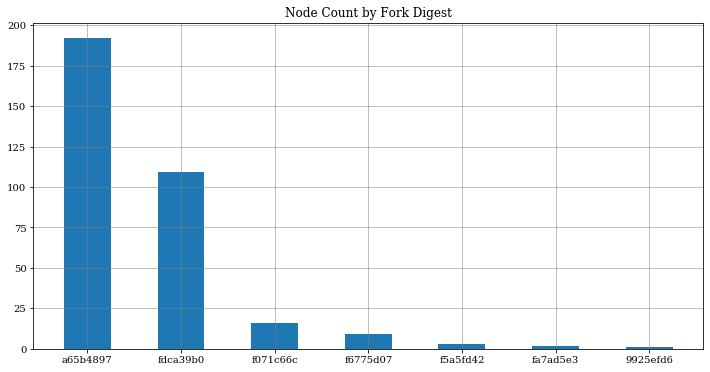

In [31]:
import matplotlib
%matplotlib inline
from collections import Counter 
import numpy as np
import matplotlib.pyplot as plt


fork_digests = df_all["fork_digest"].to_list()

counts = Counter(fork_digests)
counts = sorted(counts.items(), key=lambda i: i[1], reverse=True)
labels, values  = zip(*counts)

indexes = np.arange(len(labels))
width = .5
plt.rc('font', family='serif')
plt.figure(figsize=(12,6))
plt.title('Node Count by Fork Digest')
plt.bar(indexes, values, width)
plt.xticks(indexes, labels)
plt.grid(linestyle='-', linewidth='0.5', color='grey')
plt.show()

In [32]:
display(md("> #### Only nodes with fork-digest `{}` are members of the `{}` network.".format(FORK_DIGEST,NETWORK.title())))

> #### Only nodes with fork-digest `fdca39b0` are members of the `Altona` network.

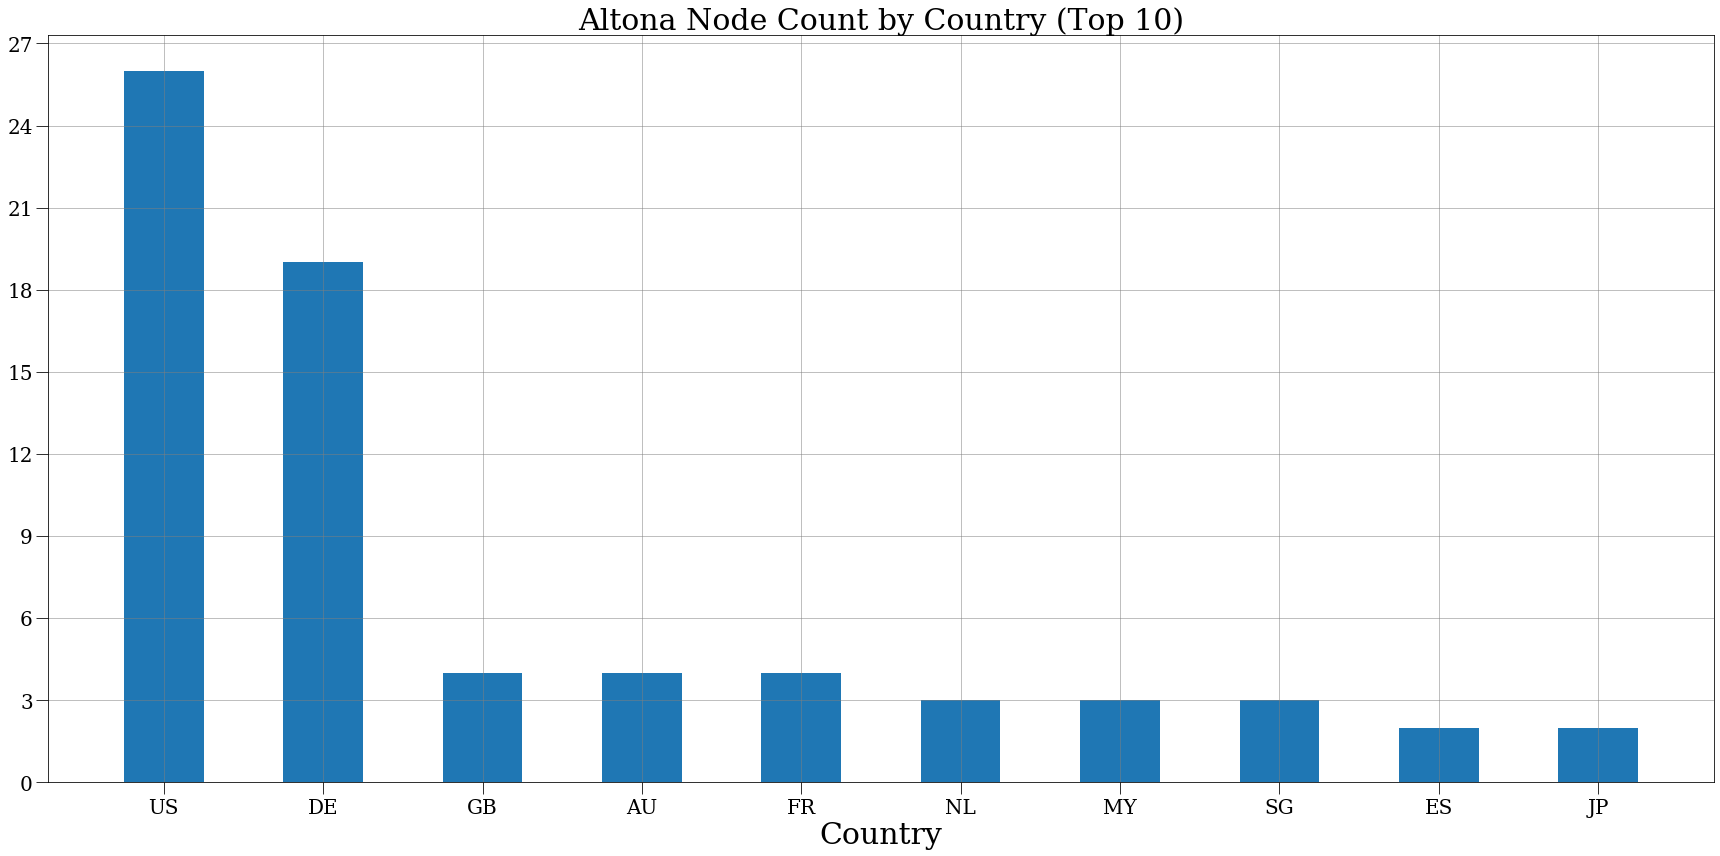

In [33]:
import matplotlib.pyplot as plt
from collections import Counter 
from matplotlib.ticker import MaxNLocator

#plot node count by country
countries=[]
for ip,info in ips_info.items():
    if info['country_name'] != None:
        countries.append(info['country'])
        
counts = Counter(countries)
counts = sorted(counts.items(), key=lambda i: i[1], reverse=True)
title_text = NETWORK.title()+' Node Count by Country'
if len(counts) >= 10:
    title_text = NETWORK.title()+' Node Count by Country (Top 10)'
    counts = counts[:10]
labels, values  = zip(*counts)

indexes = np.arange(len(labels))
width = .5
fig,ax = plt.subplots(1,figsize=(24,12))
ax.set_title(title_text,fontsize=30)
ax.bar(indexes, values, width)
ax.set_xticks(indexes)
ax.set_xticklabels(labels)
ax.set_xlabel("Country",fontsize=30)
ax.tick_params(size=12,labelsize=20)
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
plt.grid(linestyle='-', linewidth='0.5', color='grey')
plt.rc('font', family='serif')
plt.tight_layout()
plt.show()

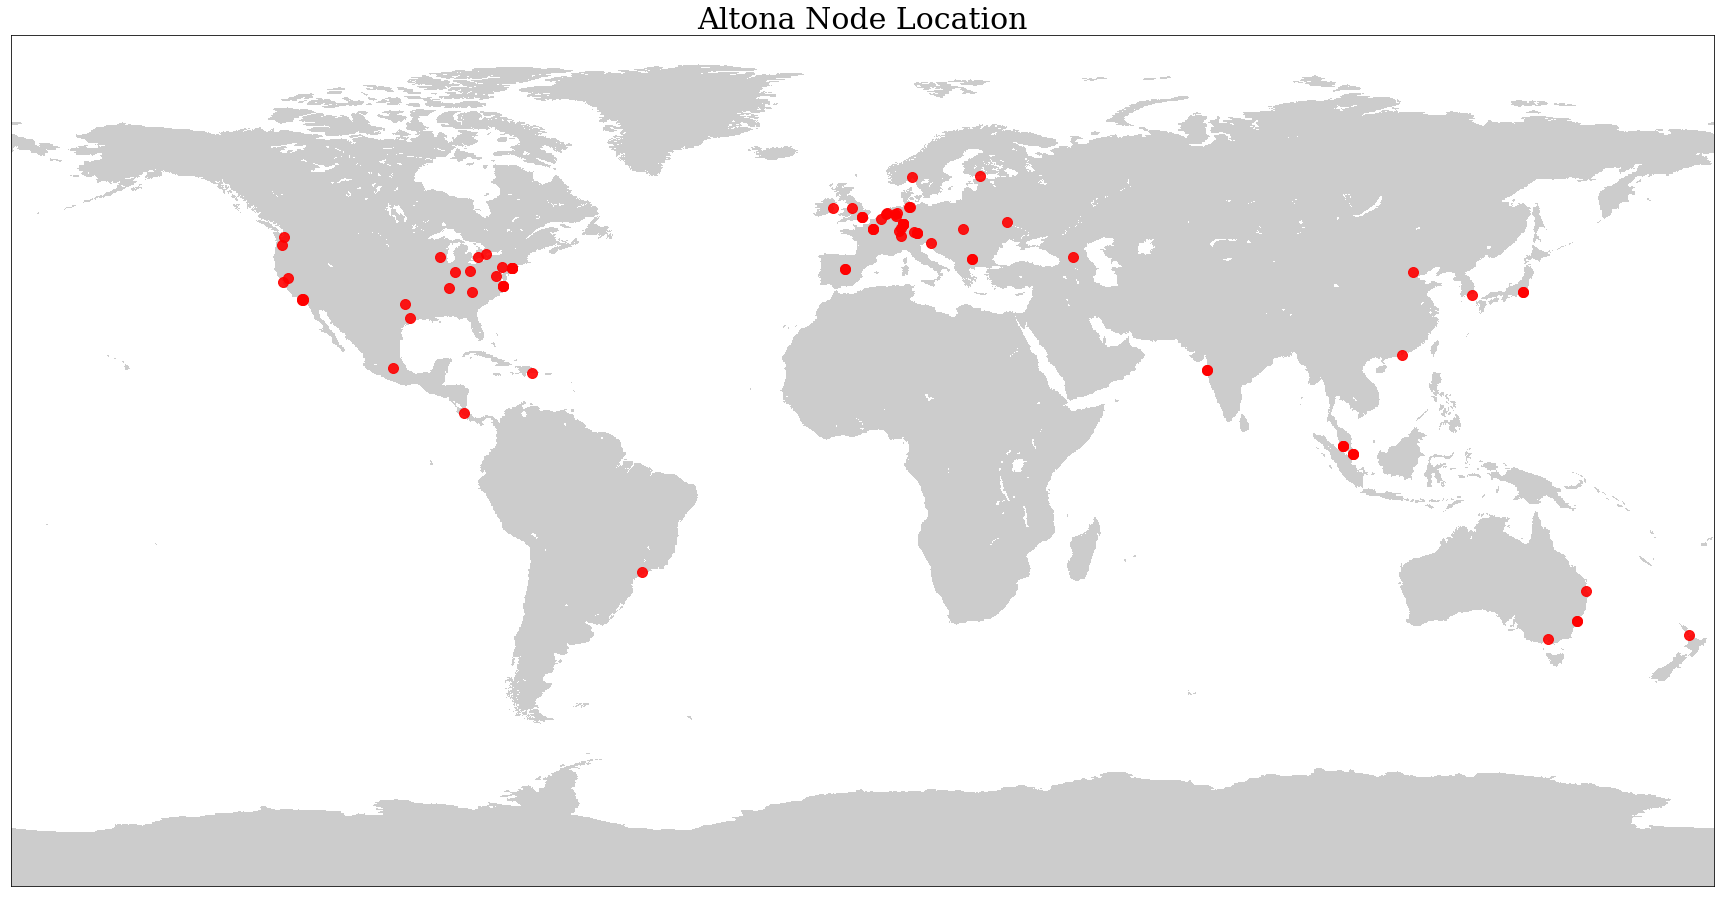

In [34]:
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
from collections import Counter 
import numpy as np

# plot nodes on map
lats=[]
lons=[]
for ip,info in ips_info.items():
    if info['country_name'] != None:
        lats.append(float(info['latitude']))
        lons.append(float(info['longitude']))

fig,ax = plt.subplots(1,figsize=(24,24))
map = Basemap(projection='cyl', resolution='l',ax=ax)
map.drawlsmask()
x, y = map(lons, lats)
map.scatter(x, y, s=100, color='#ff0000', marker='o', alpha=0.9)
ax.set_title(NETWORK.title()+' Node Location',fontsize=30)
plt.rc('font', family='serif')
plt.tight_layout()
plt.show()


> Node location information is gathered by geolocating ip addresses 🌍

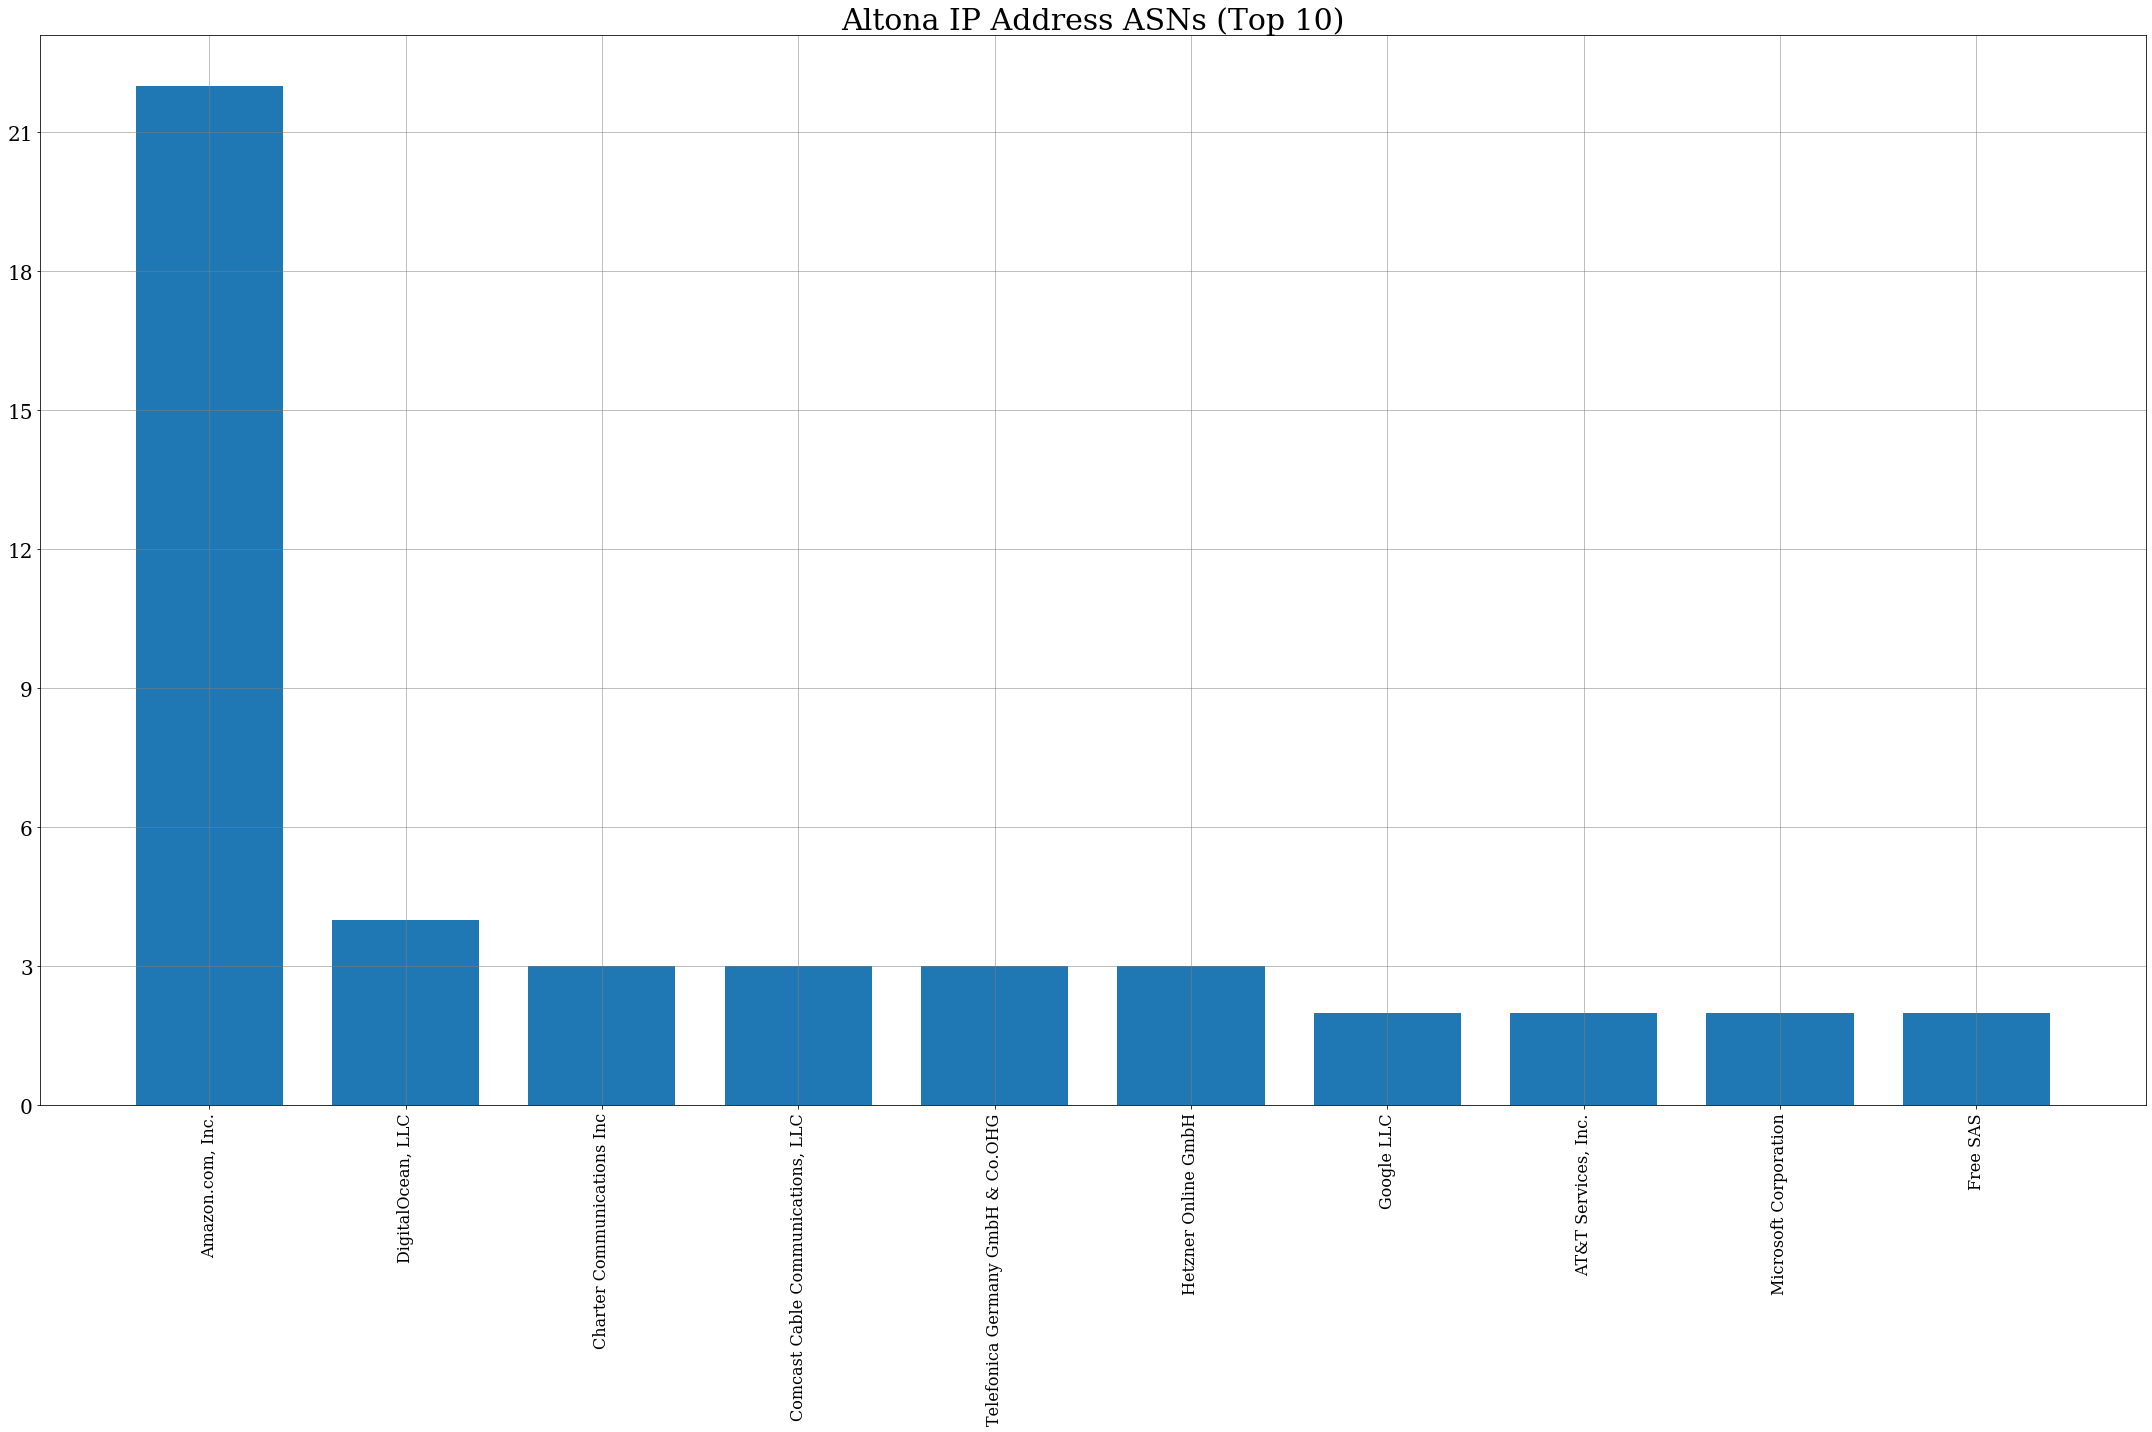

In [35]:
from collections import Counter 
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

counts = Counter(asn_orgs)
counts = sorted(counts.items(), key=lambda i: i[1], reverse=True)
title_text = NETWORK.title()+' IP Address ASNs'
if len(counts) >= 10:
    title_text = NETWORK.title()+' IP Address ASNs (Top 10)'
    counts = counts[:10]
labels, values  = zip(*counts)

indexes = np.arange(len(labels))
width = .75
plt.rc('font', family='serif')
plt.figure(figsize=(30,20))
plt.title(title_text, fontsize=30)
plt.bar(indexes, values, width)
plt.xticks(rotation=90)
plt.xticks(indexes, labels, fontsize=16)
plt.yticks(fontsize=20)
ax = plt.axes()
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
plt.grid(linestyle='-', linewidth='0.5', color='grey')
plt.tight_layout()
plt.show()


> This plot gives us an idea of the network's reliance on ISPs and cloud providers.

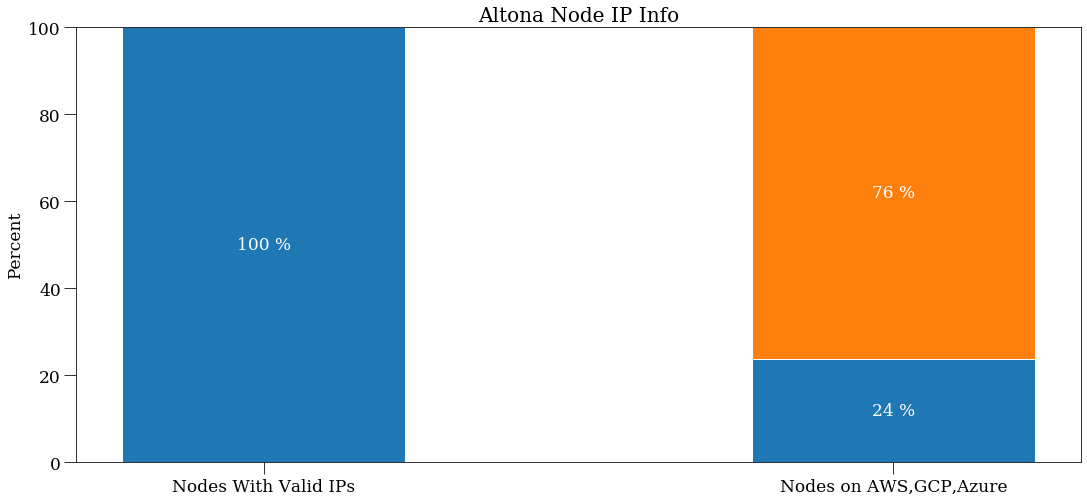

In [36]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
from collections import Counter 

NUM_NODES = len(df)
df_nodes_with_bad_ip = df_all_with_dups[df_all_with_dups['node_id'].isin(bad_ip_node_ids)].drop_duplicates(subset="node_id", keep = 'first')
PERCENT_WITH_BAD_IP = len(df_nodes_with_bad_ip[df_nodes_with_bad_ip['fork_digest']==FORK_DIGEST])/NUM_NODES
num_nodes_cloud_hosted = 0
for org in asn_orgs:
    if "Amazon"  in org or "Google" in org or "Microsoft" in org:
        num_nodes_cloud_hosted += 1
    
PERCENT_CLOUD_HOSTED=num_nodes_cloud_hosted/NUM_NODES



# Data
r = [0,1]
raw_data = {'blueBars': [1-PERCENT_WITH_BAD_IP,PERCENT_CLOUD_HOSTED], 'orangeBars': [PERCENT_WITH_BAD_IP,1-PERCENT_CLOUD_HOSTED]}
df_nodes = pd.DataFrame(raw_data)
 
# From raw value to percentage
totals = [i+j for i,j in zip(df_nodes['blueBars'], df_nodes['orangeBars'])]
blueBars = [i / j * 100 for i,j in zip(df_nodes['blueBars'], totals)]
orangeBars = [i / j * 100 for i,j in zip(df_nodes['orangeBars'], totals)]
 
# plot
barWidth = 0.45
names = ('Nodes With Valid IPs','Nodes on AWS,GCP,Azure')
fig,ax = plt.subplots(figsize=(18,8))
ax.bar(r, blueBars, color='C0', edgecolor='white', width=barWidth)
ax.bar(r, orangeBars, bottom=blueBars, color='C1', edgecolor='white', width=barWidth)
ax.set_ylabel('Percent',fontsize=17)
ax.tick_params(size=12,labelsize=17)

for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    if height > 5:
        ax.text(x+width/2, 
                y+height/2, 
                '{:.0f} %'.format(height), 
                horizontalalignment='center', 
                verticalalignment='center',
                fontsize = 17,
                color='white')

plt.title(NETWORK.title()+' Node IP Info',fontsize=20)
# Custom x axis
plt.xticks(r, names)
plt.rc('font', family='serif')
# Show graphic
plt.show()


> - **Nodes with Valid IPs:** IP address within one of the private IPv4 network ranges were considered invalid.
> - **Nodes on AWS, GCP, Azure:** IP addresses that corresponded to an ASN that belongs to Amazon, Google, or Microsoft.

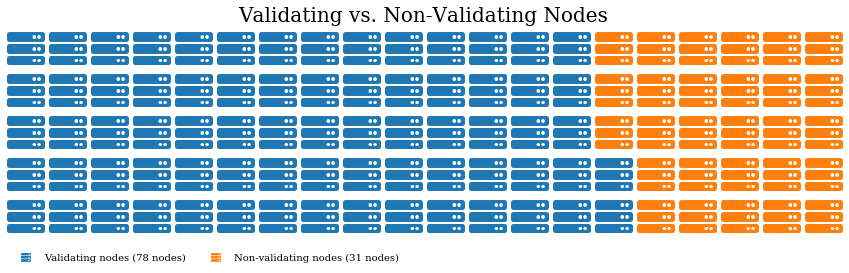

In [37]:
import matplotlib.pyplot as plt
from pywaffle import Waffle

# - 105 nodes * .56 = 58.8 ~ 59 validating nodes
# - 453 subnet subscriptions
# - 832 active validators
# 453/59 ~ 7.7 subnet subscriptions per node
# 453/64 ~ 7 subscriptions per subnet
# 832/59

vc_list = []
for ids_str in df["subnet_ids"].to_list():
    ids = eval(ids_str)
    vc_list.append(len(ids))
        
df_vc = pd.DataFrame(vc_list, columns =['subnet count group']) 

bins = list(range(0, 64, 7))+[64]
df_vc['buckets']=pd.cut(df_vc['subnet count group'], bins)
df_vc['subnet_ids']=df["subnet_ids"].reset_index(drop=True)

subnet_count_per_node = list(df_vc['subnet count group'])
validating_node_count = sum([1 for i in subnet_count_per_node if i > 0])
#consider any node with gte 64 subnet subscriptions a supernode
supernode_count = sum([1 for i in subnet_count_per_node if i==64])
num_subnet_subscriptions = sum(subnet_count_per_node)
#calc num validators on reg nodes
validators_on_regnodes = sum([i for i in subnet_count_per_node if i<64])
#calc number of validators hosted on supernodes
validators_on_supernodes = active_validators - validators_on_regnodes

data = {'Validating nodes': 100*validating_node_count/num_nodes,
        'Non-validating nodes': 100*(1-validating_node_count/num_nodes)}
legend_data = {'Validating nodes': validating_node_count,
        'Non-validating nodes': num_nodes-validating_node_count}
fig = plt.figure(
    FigureClass=Waffle, 
    rows=5,
    values=data, 
    colors=("C0","C1"),
    title={'label': 'Validating vs. Non-Validating Nodes', 'loc': 'center','fontsize':'20'},
    labels=["{0} ({1} nodes)".format(k, v) for k, v in legend_data.items()],
    legend={'loc': 'lower left', 'bbox_to_anchor': (0, -0.2), 'ncol': 2, 'framealpha': 0},
    icons='server', icon_size=38, 
    icon_legend=True,
    figsize=(12, 12)
)
plt.show()

> If a node's ENR indicated that it belonged to one or more persistent committees, then it was considered a validating node.

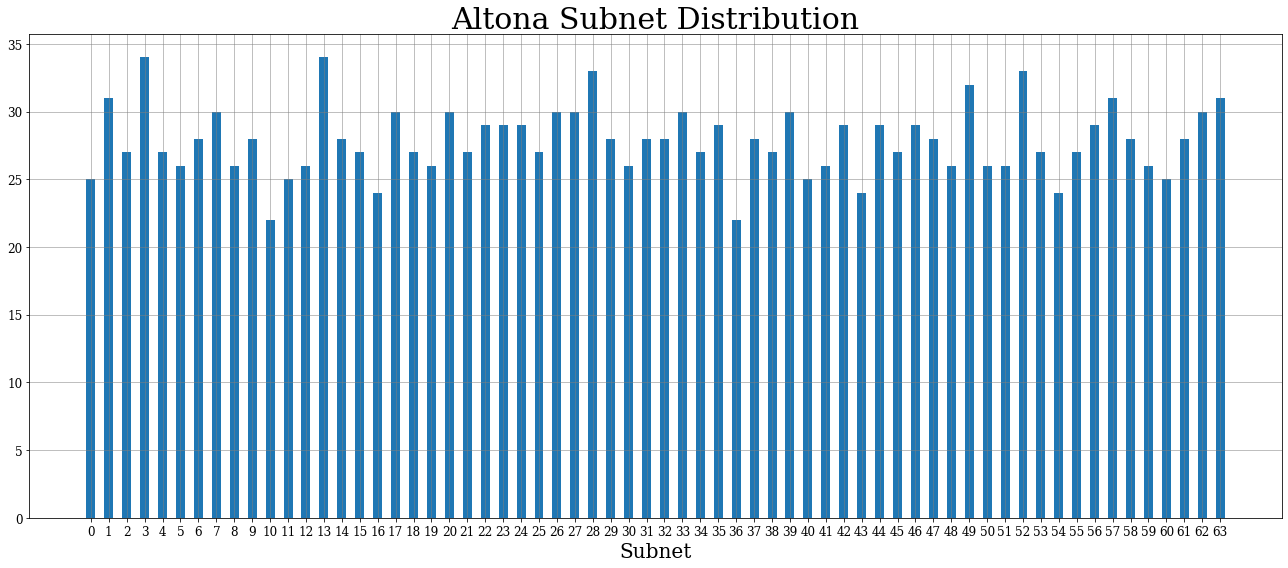

In [38]:
import numpy as np
import matplotlib.pyplot as plt

subnets = df["subnet_ids"].to_list()
subnets = [subnet.replace('[','').replace(']','').replace(' ','') for subnet in subnets]
subnets = [subnet if len(subnet) > 0 else '    None' for subnet in subnets]
subnets = ','.join(subnets)
subnets = subnets.split(',')
labels = [str(label) for label in list(range(0,64))]# + ['    None']
values = [subnets.count(label) for label in labels]

indexes = np.arange(len(labels))
width = .5
plt.figure(figsize=(18,8))
plt.title(NETWORK.title()+' Subnet Distribution',fontsize=30)
plt.bar(indexes, values, width)
plt.yticks(fontsize=12)
plt.xticks(indexes, labels,fontsize=12)
plt.xlabel("Subnet",fontsize=20)
plt.rc('font', family='serif')
plt.grid(linestyle='-', linewidth='0.5', color='grey')
plt.tight_layout()
plt.show()


> Subnet subscriptions should be evenly distributed from `0 - 63`.

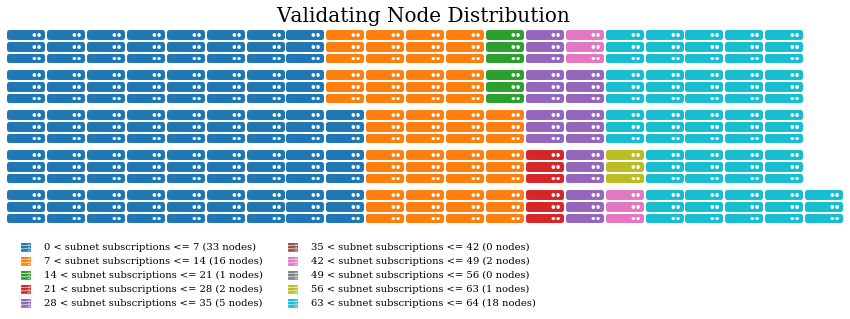

In [39]:
import matplotlib.pyplot as plt
from pywaffle import Waffle

groups = pd.DataFrame(df_vc.groupby(pd.cut(df_vc['subnet count group'], bins)).size(), columns =['count']).reset_index()
#groups = groups[groups['count']>0]
data = {}
legend_data = {}
for k,v in zip(list(groups['subnet count group']),list(groups['count'])):
    key="{} < subnet subscriptions <= {}".format(k.left,k.right)
    data[key]=v/validating_node_count*100
    legend_data[key]=v
    
fig = plt.figure(
    FigureClass=Waffle, 
    rows=5,
    values=data, 
    colors=('C0', 'C1', 'C2', 'C3', 'C4','C5','C6','C7','C8','C9'),
    title={'label': 'Validating Node Distribution', 'loc': 'center','fontsize':'20'},
    labels=["{0} ({1} nodes)".format(k, v) for k, v in legend_data.items()],
    legend={'loc': 'lower left', 'bbox_to_anchor': (0, -0.5), 'ncol': 2, 'framealpha': 0},
    icons='server', icon_size=38, 
    icon_legend=True,
    figsize=(12, 12),
    rounding_rule='ceil'
)
plt.show()


> This chart bucketizes nodes by the number of subnets they are subscribed to.  This info can be used to estimate how many validators a particular node hosts. 😅

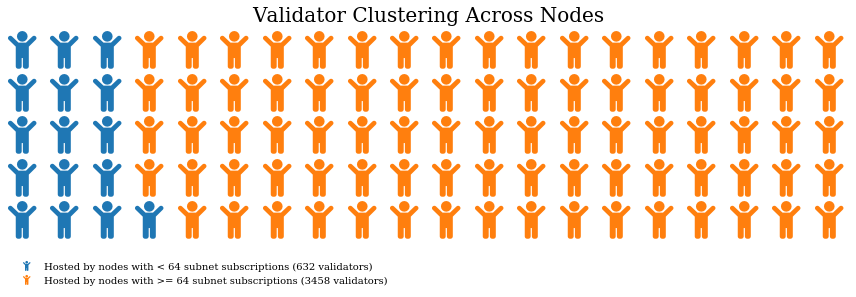

In [40]:


data = {'Regularnodes': 100*validators_on_regnodes/active_validators,
        'Supernodes': 100*validators_on_supernodes/active_validators}
legend_data = {'Hosted by nodes with < 64 subnet subscriptions': validators_on_regnodes,
        'Hosted by nodes with >= 64 subnet subscriptions': validators_on_supernodes}
fig = plt.figure(
    FigureClass=Waffle, 
    rows=5,
    values=data, 
    colors=('C0', 'C1'),
    title={'label': 'Validator Clustering Across Nodes', 'loc': 'center','fontsize':'20'},
    labels=["{0} ({1} validators)".format(k, v) for k, v in legend_data.items()],
    legend={'loc': 'lower left', 'bbox_to_anchor': (0, -0.3), 'ncol': 1, 'framealpha': 0},
    icons='child', icon_size=38, 
    icon_legend=True,
    figsize=(12, 12)
)
plt.show()


> Again, the subnet subscriptions are used to bucketize nodes.  If a node has < 64 subnet subscriptions, then it is blue; otherwise, orange.  A good rule of thumb to use when interpreting this chart is:
> - if you see a lot of blue, then validators probably fairly evenly spread across many nodes.  
> - if you see a lot of orange, then most validators are probably hosted on just a few nodes.

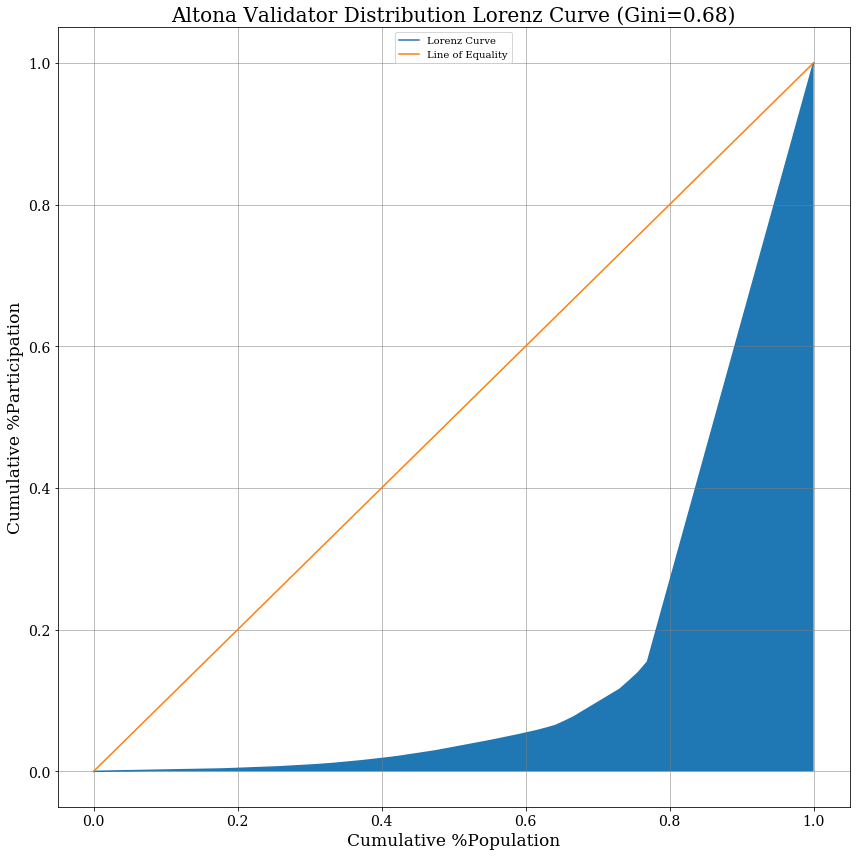

In [41]:
import numpy as np
import matplotlib.pyplot as plt


sorted_subnet_count_per_node=sorted([i for i in subnet_count_per_node if i > 0])
sorted_subnet_count_per_node=[i if i < 64 else validators_on_supernodes/supernode_count for i in sorted_subnet_count_per_node]

arr = np.array(sorted_subnet_count_per_node)

def gini(arr):
    count = arr.size
    coefficient = 2 / count
    indexes = np.arange(1, count + 1)
    weighted_sum = (indexes * arr).sum()
    total = arr.sum()
    constant = (count + 1) / count
    return coefficient * weighted_sum / total - constant

def lorenz(arr):
    # this divides the prefix sum by the total sum
    # this ensures all the values are between 0 and 1.0
    scaled_prefix_sum = arr.cumsum() / arr.sum()
    # this prepends the 0 value (because 0% of all people have 0% of all wealth)
    return np.insert(scaled_prefix_sum, 0, 0)

lorenz_curve = lorenz(arr)



plt.rc('font', family='serif')
plt.figure(figsize=(12,12))
plt.title(NETWORK.title()+' Validator Distribution Lorenz Curve (Gini={})'.format(round(gini(arr),2)), fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
ax = plt.axes()
ax.set_ylabel('Cumulative %Participation',fontsize=17)
ax.set_xlabel('Cumulative %Population',fontsize=17)
plt.grid(linestyle='-', linewidth='0.5', color='grey')
x=np.linspace(0.0, 1.0, lorenz_curve.size)
plt.plot(x,lorenz_curve,label='Lorenz Curve')
ax.fill_between(x,0,lorenz_curve)
plt.plot([0,1], [0,1],label='Line of Equality')
plt.legend(loc='upper center')
plt.tight_layout()
plt.show()



> The Gini coefficient and Lorenz Curve is another way to look at the distribution of validators across nodes.  The closer the Gini coefficient is to zero, the more evenly distributed the validators are. Similarly, if every validating node hosted the same number of validators, then the shaded region would be the area under the 'Line of Equality' y=x.

In [42]:
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter 
node_ids = df["node_id"].to_list()
node_ids = [node_id.strip() for node_id in node_ids]
node_ids_freq = [Counter(node_id) for node_id in node_ids]
hex_chars = ['0','1','2','3','4','5','6','7','8','9','a','b','c','d','e','f']
freqs = []
for node_id_freq in node_ids_freq:
    freqs.append([node_id_freq[hex_char] for hex_char in hex_chars])

x, y = np.meshgrid(hex_chars, node_ids)
intensity = np.array(freqs)

#plt.title(NETWORK.title()+' NodeId Character Heatmap',fontsize=40)
#plt.pcolormesh(x, y, intensity)
#plt.colorbar()
#plt.rc('font', family='serif')
#plt.xticks(fontsize=40)
#plt.rcParams["figure.figsize"] = (50,50)
#plt.tight_layout()
#plt.show()

In [45]:
pd.set_option('display.max_columns', None)  
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.width', None)

#print(df[(df['next_fork_version']!=113) | (df['next_fork_epoch']!=18446744073709551615)])


In [46]:
#for ip in ips_info:
#    info = ips_info[ip]
#    if info['country_name'] != None:
#        if info['city'] == 'Madrid':
#            print(df[df['ip4']==info['ip']])


In [47]:
pd.reset_option('display.max_columns')
pd.reset_option('display.expand_frame_repr')
pd.reset_option('display.max_colwidth')
pd.reset_option('display.width')

In [ ]:
df_dht = df
coordinates=[]
for node_id,ip in zip(df_dht["node_id"].to_list(),df_dht["ip4"].to_list()):
    if node_id not in bad_ip_node_ids:
        coordinates.append((ips_info[ip]['loc']))
    else:
        coordinates.append((0,0))

df_dht["coordinates"]=coordinates

%store df_dht